In [1]:
#task 2:data exploration and model development

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
import datetime as dt



# import the bike data as csv
pd.set_option('max_columns',None)
pd.set_option('max_rows',None)
demographic_df=pd.read_csv("CustomerDemographic.csv",header=1,index_col='customer_id')
transactions_df=pd.read_csv("Transactions.csv",header=0,index_col='transaction_id')
transactions_df.columns








Index(['product_id', 'customer_id', 'transaction_date', 'comparison date',
       'recency (days)', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'profit', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'Unnamed: 25'],
      dtype='object')

In [2]:
#convert DOB to date type
demographic_df['DOB']=pd.to_datetime(demographic_df['DOB'])



In [3]:
#get current datetime
demographic_df['Now']=dt.datetime.now()
#calculate difference
demographic_df['Age']=(demographic_df['Now']-demographic_df['DOB'])/np.timedelta64(1,'Y')
#always round down the age to get whole number
demographic_df['Age']=np.floor(demographic_df['Age'])
demographic_df['Age'].head()









customer_id
1    68.0
2    41.0
3    68.0
4    61.0
5    45.0
Name: Age, dtype: float64

In [4]:
#set profit as float type from type object and remove the dollar sign.
transactions_df['profit']=transactions_df['profit'].str.replace('$','')
transactions_df['profit']=transactions_df['profit'].str.replace(',','')
transactions_df['profit']=transactions_df['profit'].astype('float64')

/var/folders/k8/qdkczwt57kvdh59cmc0ccfb40000gn/T/ipykernel_89444/2290559954.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  transactions_df['profit']=transactions_df['profit'].str.replace('$','')


In [5]:
# Drop records which have order status = cancelled
transactions_df = transactions_df.drop(transactions_df[transactions_df['order_status'] == 'Cancelled'].index)

In [6]:
transactions_df['order_status'].unique()





array(['Approved'], dtype=object)

In [7]:
demographic_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Now,Age
customer_id,,,,,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-12-10,Executive Secretary,Health,Mass Customer,N,Yes,11.0,2022-07-24 11:41:01.805823,68.0
2,Eli,Bockman,M,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,2022-07-24 11:41:01.805823,41.0
3,Arlin,Dearle,M,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,2022-07-24 11:41:01.805823,68.0
4,Talbot,NaN,M,33,1961-03-10,NaN,IT,Mass Customer,N,No,7.0,2022-07-24 11:41:01.805823,61.0
5,Sheila-kathryn,Calton,F,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,2022-07-24 11:41:01.805823,45.0


In [8]:
# calculate recency,frequency and monetary for RFM
RFM_df=transactions_df.groupby('customer_id').agg({
'recency (days)':lambda x:x.min(),
'customer_id':lambda x:len(x),
'profit':lambda x:x.sum()
        })

RFM_df.rename(columns={
'recency (days)':'recency',
'customer_id':'frequency',
'profit' : 'monetary value'
},inplace=True)

RFM_df.head()




,recency,frequency,monetary value
customer_id,,,
1,7,11,3018.09
2,128,3,2226.26
3,102,8,3362.81
4,195,2,220.57
5,16,6,2394.94


In [9]:
#compute the quartile each value falls on

quartile=RFM_df.quantile(q=[0.25,0.5,0.75])

quartile['recency']

0.25    17.0
0.50    44.0
0.75    87.0
Name: recency, dtype: float64

In [10]:
#create function that converts the quartiles into RFM values. high value means better customer
def R_value(x,q,column):
    if x<=q[column][0.25]:
        return 4
    elif x<=q[column][0.5]:       
        return 3
    elif x<=q[column][0.75]:      
        return 2
    else:
        return 1
    
    
def FM_value(x,q,column):
    if x<=q[column][0.25]:
        return 1
    elif x<=q[column][0.5]:       
        return 2
    elif x<=q[column][0.75]:
        return 3
    else:
        return 4
    
        


In [11]:
# create 3 new columns and pass  recency, count product id and monetary value into the functions

RFM_df['R_value']=RFM_df['recency'].apply(R_value,args=(quartile,'recency'))
RFM_df['F_value']=RFM_df['frequency'].apply(FM_value,args=(quartile,'frequency'))
RFM_df['M_value']=RFM_df['monetary value'].apply(FM_value,args=(quartile,'monetary value'))
RFM_df.head()
#Series.apply(func, convert_dtype=True, args=(), **kwargs)


,recency,frequency,monetary value,R_value,F_value,M_value
customer_id,,,,,,
1,7,11,3018.09,4,4,3
2,128,3,2226.26,1,1,2
3,102,8,3362.81,1,4,3
4,195,2,220.57,1,1,1
5,16,6,2394.94,4,3,2


In [12]:
# create RFM score column which adds each score by digit

RFM_df['RFM score']=100*RFM_df['R_value']+10*RFM_df['F_value']+RFM_df['M_value']

In [14]:
quartile=RFM_df.quantile(q=[0.25,0.5,0.75])
quartile['RFM score']

0.25    211.0
0.50    311.0
0.75    411.0
Name: RFM score, dtype: float64

In [15]:
# add loyalty column which categorises the customers by their score
def loyalty(x,q,column):
    """
    """
    if x<=q[column][0.25]:
        return 'a) poor'
    elif x<=q[column][0.5]:       
        return 'b) avarage'
    elif x<=q[column][0.75]:      
        return 'c) good'
    else:
        return 'd) excellent'
    

RFM_df['customer loyalty']=RFM_df['RFM score'].apply(loyalty,args=(quartile,'RFM score'))
 
    
    

In [16]:
# add title column which categorises the customers by their score in detail
def title(RFM):
    """
    """
    if (RFM==444):
        return 'a) most loyal customer'
    elif (433<=RFM<444):
        return 'b) very loyal customer'
    elif (421<=RFM<433):
        return 'c) Becoming loyal'
    elif (344<=RFM<421):
        return 'd) Recent customer'
    elif (323<=RFM<344):
        return 'e) Potential customer'  
    elif (311<=RFM<323):
        return 'f) first time buyer'
    elif(224<=RFM<311):
        return 'g) losing customer'
    elif(212<=RFM<224):
        return 'h) Could be lost'
    elif(124<=RFM<212):
        return 'i) On the brink of losing customer'
    elif(112<=RFM<124):
        return 'j)Evasive Customer '
    elif(111<=RFM<112):
        return 'k) Lost customer'

RFM_df['customer_title']=RFM_df['RFM score'].apply(title)  

<AxesSubplot:>

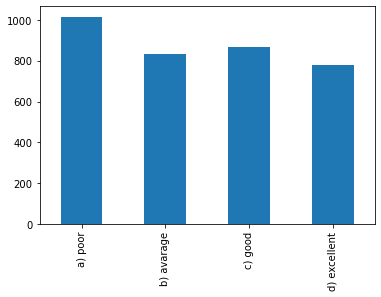

In [17]:
#create RFM graph for customer loyalty
count=RFM_df['customer loyalty'].value_counts().sort_index(ascending=True)
count.plot.bar(x=RFM_df['customer loyalty'].unique(),y=count)


In [18]:
count

a) poor         1015
b) avarage       831
c) good          867
d) excellent     780
Name: customer loyalty, dtype: int64

<AxesSubplot:>

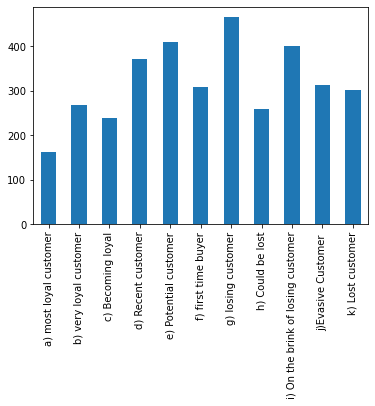

In [19]:
# create customer title bar chart
count=RFM_df['customer_title'].value_counts().sort_index(ascending=True) 
count.plot.bar(stacked=True)



([<matplotlib.patches.Wedge at 0x7fab49d09ca0>,
 [Text(1.0882005290199832, 0.16068481148082722, 'a) most loyal customer'),
  Text(0.9472239011005238, 0.5592556492194829, 'b) very loyal customer'),
  Text(0.6058215236417344, 0.918139576258647, 'c) Becoming loyal'),
  Text(0.040059230383665684, 1.0992703298375102, 'd) Recent customer'),
  Text(-0.6788549655200218, 0.8655379458977002, 'e) Potential customer'),
  Text(-1.062795307387791, 0.28366553296883185, 'f) first time buyer'),
  Text(-0.9982469973707793, -0.4620637750789644, 'g) losing customer'),
  Text(-0.5147971371991926, -0.9721028276532868, 'h) Could be lost'),
  Text(0.11504688032317055, -1.0939671911569864, 'i) On the brink of losing customer'),
  Text(0.7466172453319868, -0.807813523638269, 'j)Evasive Customer '),
  Text(1.0596719290625263, -0.2951193025827093, 'k) Lost customer')],
 [Text(0.5935639249199908, 0.08764626080772393, '4.7%'),
  Text(0.5166675824184674, 0.30504853593789977, '7.6%'),
  Text(0.33044810380458234, 0.50

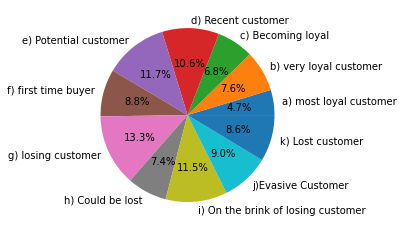

In [20]:
#create pie chart of the customer titles

category= RFM_df['customer_title'].value_counts().sort_index(ascending=True)
def func(pct, allvals):
    return "{:.1f}%".format(pct)

plt.pie(category,labels=category.index,autopct=lambda pct:func(pct,category))



/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'recency vs monetary value')

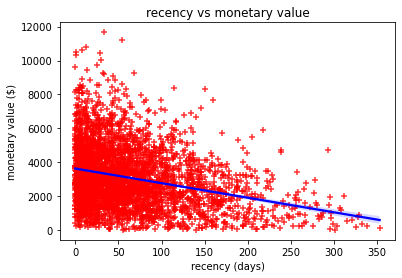

In [21]:
# scatter plot of recency vs monetary value
sns.regplot(RFM_df['recency'],RFM_df['monetary value'],scatter_kws={'color':'red'},line_kws={'color':'blue'},marker='+')
plt.xlabel('recency (days)')
plt.ylabel('monetary value ($)')
plt.title('recency vs monetary value')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'recency vs frequency')

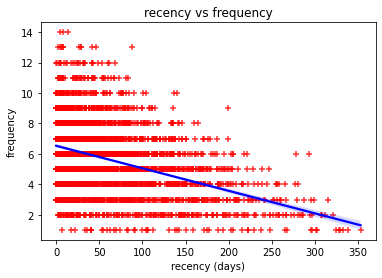

In [22]:
# scatter plot of recency vs frequency
sns.regplot(RFM_df['recency'],RFM_df['frequency'],scatter_kws={'color':'red'},line_kws={'color':'blue'},marker='+')
plt.xlabel('recency (days)')
plt.ylabel('frequency')
plt.title('recency vs frequency')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'frequency vs monetary value')

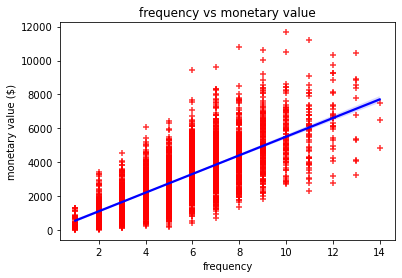

In [23]:
# scatter plot of frequency vs monetary value
sns.regplot(RFM_df['frequency'],RFM_df['monetary value'],scatter_kws={'color':'red'},line_kws={'color':'blue'},marker='+')
plt.xlabel('frequency')
plt.ylabel('monetary value ($)')
plt.title('frequency vs monetary value')

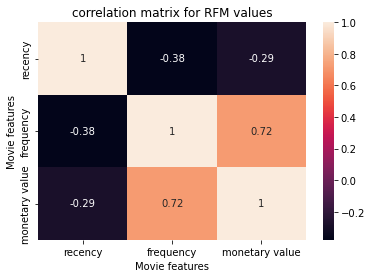

In [24]:
#create a heatmap of the correlations between frequency,monetary value, recency
matrix_df=RFM_df[['recency','frequency','monetary value']].copy()
RFM_matrix=matrix_df.corr(method='pearson')

sns.heatmap(RFM_matrix,annot=True)
plt.title('correlation matrix for RFM values')
plt.xlabel('Movie features')
plt.ylabel('Movie features')
plt.show()

In [25]:
#Add age to RFM df
RFM_df['Age']=demographic_df['Age']

In [26]:
RFM_df.head()

,recency,frequency,monetary value,R_value,F_value,M_value,RFM score,customer loyalty,customer_title,Age
customer_id,,,,,,,,,,
1,7,11,3018.09,4,4,3,443,d) excellent,b) very loyal customer,68.0
2,128,3,2226.26,1,1,2,112,a) poor,j)Evasive Customer,41.0
3,102,8,3362.81,1,4,3,143,a) poor,i) On the brink of losing customer,68.0
4,195,2,220.57,1,1,1,111,a) poor,k) Lost customer,61.0
5,16,6,2394.94,4,3,2,432,d) excellent,c) Becoming loyal,45.0


In [27]:
#Classify the ages into age classes

RFM_df['Age class']=np.ceil(RFM_df['Age']/10)*10
RFM_df.head()

,recency,frequency,monetary value,R_value,F_value,M_value,RFM score,customer loyalty,customer_title,Age,Age class
customer_id,,,,,,,,,,,
1,7,11,3018.09,4,4,3,443,d) excellent,b) very loyal customer,68.0,70.0
2,128,3,2226.26,1,1,2,112,a) poor,j)Evasive Customer,41.0,50.0
3,102,8,3362.81,1,4,3,143,a) poor,i) On the brink of losing customer,68.0,70.0
4,195,2,220.57,1,1,1,111,a) poor,k) Lost customer,61.0,70.0
5,16,6,2394.94,4,3,2,432,d) excellent,c) Becoming loyal,45.0,50.0


Text(0.5, 1.0, 'existing customer age distribution')

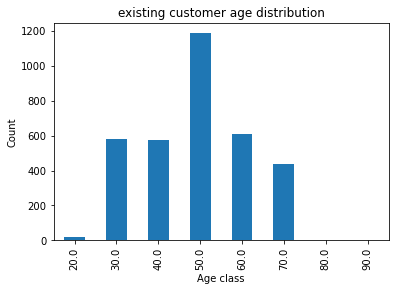

In [28]:
#create bar plot of the age classes
count=RFM_df['Age class'].value_counts().sort_index(ascending=True)
count.plot(kind='bar')
plt.xlabel('Age class')
plt.ylabel('Count')
plt.title('existing customer age distribution')



Text(0.5, 1.0, 'existing customer age distribution per wealth segment')

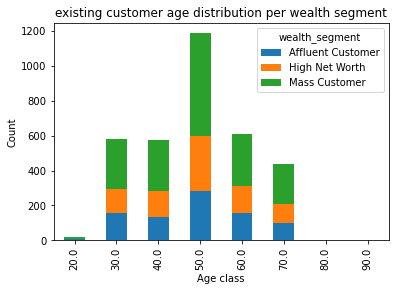

In [29]:
# create bar plot of existing customer age group per wealth segment
wealth=demographic_df['wealth_segment'].groupby(RFM_df['Age class']).value_counts()
wealth.unstack(level=1).plot.bar(stacked=True)
plt.xlabel('Age class')
plt.ylabel('Count')
plt.title('existing customer age distribution per wealth segment')

In [30]:
#import NewCustomerList 
new_customer_df=pd.read_csv('newcustomerlist.csv')

new_customer_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Rank,Value,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256
0,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5,0.68,0.6800,0.680000,0.68,698.0,1,1,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [31]:
#create new columns for age and age class

new_customer_df['DOB']=pd.to_datetime(new_customer_df['DOB'])
#get current datetime
new_customer_df['Now']=dt.datetime.now()
#calculate difference
new_customer_df['Age']=(new_customer_df['Now']-new_customer_df['DOB'])/np.timedelta64(1,'Y')
#always round down the age to get whole number
new_customer_df['Age']=np.floor(new_customer_df['Age'])
new_customer_df['Age'].head()


0    47.0
1    65.0
2    52.0
3    43.0
4    56.0
Name: Age, dtype: float64

In [32]:
new_customer_df['Age class']=np.ceil(new_customer_df['Age']/10)*10
new_customer_df['Age class'].head()

0    50.0
1    70.0
2    60.0
3    50.0
4    60.0
Name: Age class, dtype: float64

Text(0.5, 1.0, 'New customer age distribution')

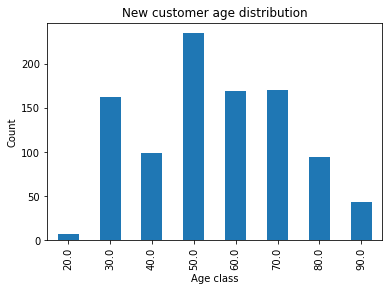

In [33]:
#create bar plot of these new customer age groups

count=new_customer_df['Age class'].value_counts().sort_index(ascending=True)
count.plot.bar()
plt.xlabel('Age class')
plt.ylabel('Count')
plt.title('New customer age distribution')


Text(0.5, 1.0, 'New customer age distribution per wealth segment')

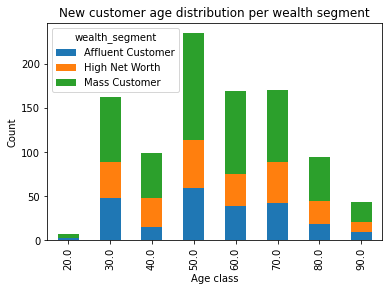

In [34]:
#create bar plot of these new customer age groups per wealth segment
wealth=new_customer_df['wealth_segment'].groupby(new_customer_df['Age class']).value_counts()
wealth.unstack(level=1).plot.bar(stacked=True)
plt.xlabel('Age class')
plt.ylabel('Count')
plt.title('New customer age distribution per wealth segment')




Text(0.5, 1.0, 'existing customer industry distribution')

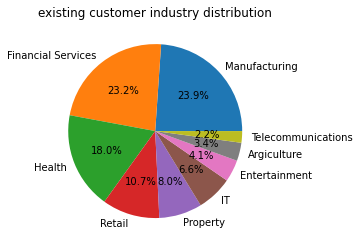

In [35]:
# create pie chart of existing customer industry distribution
category= demographic_df['job_industry_category'].value_counts()
def func(pct, allvals):
    return "{:.1f}%".format(pct)

plt.pie(category,labels=category.index,autopct=lambda pct:func(pct,category))
plt.title('existing customer industry distribution')

Text(0.5, 1.0, 'new customer industry distribution')

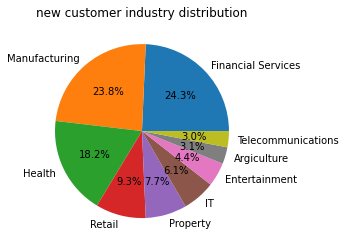

In [36]:
# create pie chart of new customer industry distribution
category= new_customer_df['job_industry_category'].value_counts()
def func(pct, allvals):
    return "{:.1f}%".format(pct)

plt.pie(category,labels=category.index,autopct=lambda pct:func(pct,category))
plt.title('new customer industry distribution')


Text(0.5, 1.0, 'last 3 years number of bike related purchases for existing customers per gender')

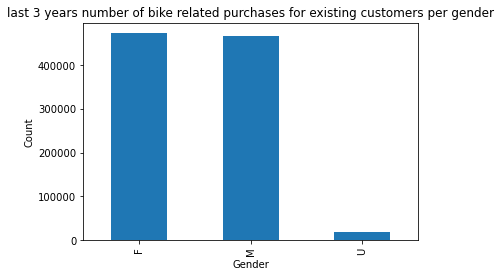

In [37]:
#bike related purchases for 3 yrs bar chart by gender existing customers

purchases=transactions_df['past_3_years_bike_related_purchases'].groupby(transactions_df['gender']).agg(lambda x:x.sum())
purchases.plot.bar(stacked=True)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('last 3 years number of bike related purchases for existing customers per gender')



Text(0.5, 1.0, 'last 3 years number of bike related purchases for new customers per gender')

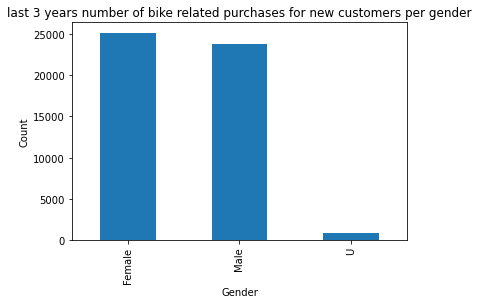

In [39]:
#bike related purchases for 3 yrs by gender bar chart 
#new customers

purchases=new_customer_df['past_3_years_bike_related_purchases'].groupby(new_customer_df['gender']).agg(lambda x:x.sum())
purchases.plot.bar(stacked=True)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('last 3 years number of bike related purchases for new customers per gender')







Text(0.5, 1.0, 'no of cars owned in each state for existing customers')

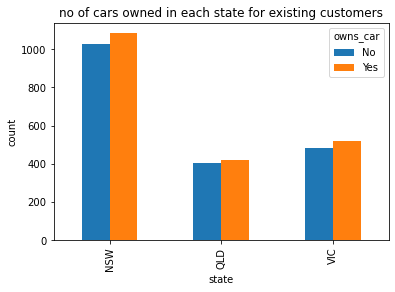

In [41]:
#no of cars owned in each state bar chart for existing customers
#import address

address_df=pd.read_csv('Address.csv')

cars_owned=transactions_df['owns_car'].groupby(address_df['state']).value_counts()
cars_owned.unstack(level=1).plot.bar()
plt.ylabel('count')
plt.title('no of cars owned in each state for existing customers')


Text(0.5, 1.0, 'no of cars owned in each state for new customers')

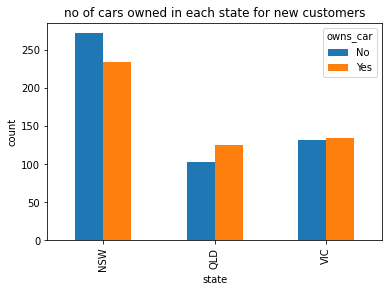

In [42]:
#no of cars owned in each state bar chart for new customers

cars_owned=new_customer_df['owns_car'].groupby(new_customer_df['state']).value_counts()
cars_owned.unstack(level=1).plot.bar()
plt.ylabel('count')
plt.title('no of cars owned in each state for new customers')




In [ ]:
transactions_df
demographic_df
RFM_df
new_customer_df

In [43]:
#save each df as a csv file for later visualisation in tableau
transactions_df.to_csv('transactions_df.csv')



In [44]:
demographic_df.to_csv('demographic_df.csv')


In [45]:
RFM_df.to_csv('RFM_df.csv')




In [46]:
new_customer_df.to_csv('new_customer_df.csv')



